# Robustness

This file is used to test the statistical robustness of the individual statistical inferences and regressions.

It is used to analyse the individual parameters and test for statistical validity and assumption testing

In [55]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy.stats import levene
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import datetime as dt

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
from src import construct_date_ranges
from configs import FILENAMES_ANALYSIS, ANALYSIS_PATHS, CONFIG

In [57]:
pred_actual: pd.DataFrame = pd.read_csv(ANALYSIS_PATHS.results_read(FILENAMES_ANALYSIS.Comp_pred_actual_portfolio),
                                        index_col=0,
                                        parse_dates=[0],
                                        header=[0,1])

factor_loadings: pd.DataFrame = pd.read_csv(ANALYSIS_PATHS.results_read(FILENAMES_ANALYSIS.Factor_loadings_monthly),
                                            index_col=[0,1])

factor_loadings_different_periods: pd.DataFrame = pd.read_csv(ANALYSIS_PATHS.results_read(FILENAMES_ANALYSIS.Factor_loadings_differentperiods),
                                                              index_col=[0,1],
                                                              header=[0,1])

## 1. Significance of Parameters using T-test and P-value

In [58]:
factor_loadings_different_periods_swapped: pd.DataFrame = factor_loadings_different_periods.swaplevel(axis=1)
filtered: pd.DataFrame = factor_loadings_different_periods_swapped.loc[("Tstat")]>CONFIG.T_TEST_SIGNIFICANCE_LEVEL

# Sum up the number of insignificant factor loadings for each date range across different industries
timeframe_count_insignificance: pd.DataFrame = filtered.T.groupby(level="date Range").sum()

In [59]:
print(timeframe_count_insignificance)

Factor           Alpha  CMA  HML  Mkt-RF  RMW  SMB
date Range                                        
01/2008:01/2015      0    0    0       1    0    1
01/2015:01/2019      2    0    0       0    0    0
01/2019:01/2022      7    0    0       0    0    0
01/2022:12/2025      0    2    0       0    0    0
Entire Period        4    0    0       1    0    0


## 2. Assumptions of the OLS

In [60]:
# dataframe to hold the statistical results
stat_res: pd.DataFrame = pd.DataFrame(index=pred_actual.columns.get_level_values(0).unique())
res_returns: pd.DataFrame = pred_actual.xs("Residual_returns", level=1, axis=1)


### Endogeneity

The different regressors are uncorrelated witht the error term

### Homoscedasticity and Normality of the error term

The error term always has the same constant variance throughout the observations and is normally distributed, centred around 0

#### Jarque-Bera Test for normality

In [61]:
for i,data in res_returns.T.iterrows():
    jb_stat, jb_pvalue, skew, kurtosis = sms.jarque_bera(data.to_numpy(dtype=float))

    stat_res.loc[i, "Jarque-Bera"] = jb_pvalue > CONFIG.P_THRESHOLD_JARQUE_BERA
        

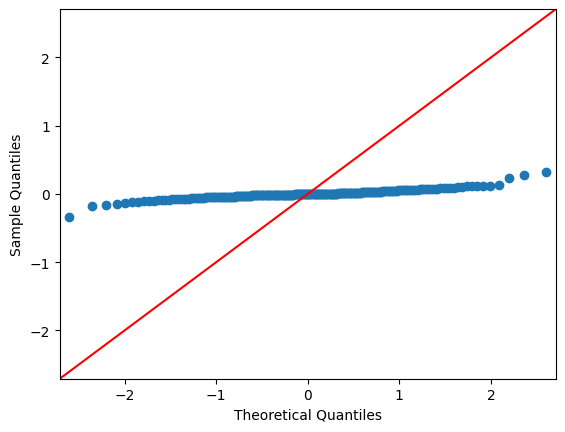

In [62]:
def qq_plot(data: pd.Series, id: str) -> None:
    sm.qqplot(data.loc[:,id], line="45")
    plt.show()

# Example usage:
qq_plot(res_returns, "Trading")

#### Test for mean error of 0

In [63]:
TOLERANCE: float = 0.0005

print(f"There are {sum(abs(res_returns.mean(axis=0)) > TOLERANCE)} industries with mean residual returns greater than {TOLERANCE}.")

There are 0 industries with mean residual returns greater than 0.0005.


#### Test for time-series homoscedasticity of error term

In [64]:
THRESHOLD_ARCH: float = 0.05
N_LAGS_ARCH: int = 5

for i,data in res_returns.T.iterrows():
    arch_test = het_arch(resid=data, nlags=N_LAGS_ARCH)

    stat_res.loc[i, "Time-series Homoscedasticity"] = arch_test[1] > THRESHOLD_ARCH
        

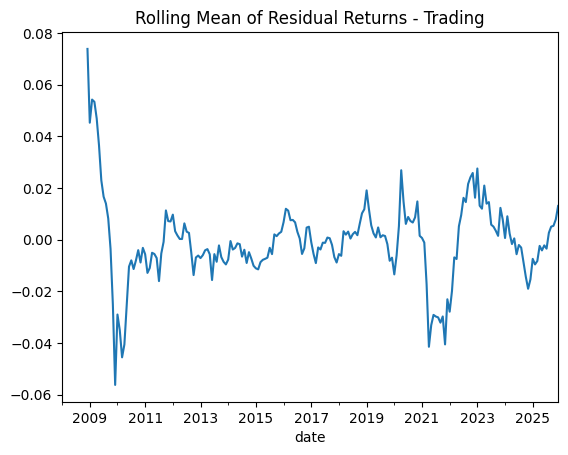

In [65]:
def rolling_res_plot(df: pd.DataFrame, id: str) -> None:
    rolling_mean = df.loc[:,id].rolling(12).mean()
    rolling_mean.plot(title=f"Rolling Mean of Residual Returns - {id}")
    plt.show()

# Example usage:
rolling_res_plot(res_returns, "Trading")

#### Test for structural breaks

In [66]:
# Get the date ranges for the different periods defined in CONFIG
group: Dict[str, Tuple[dt.datetime, dt.datetime]] = construct_date_ranges(res_returns, CONFIG)
# remove the "Entire Period" group for the Levene's test
del group["Entire Period"]

SIGNIFICANCE_LEVINE: float = 0.05

res_returns: pd.DataFrame = pred_actual.xs("Residual_returns", level=1, axis=1)

for i,data in res_returns.T.iterrows():
    periods: Tuple[pd.DataFrame] = (data.loc[start: end] for start, end in group.values())
    stat, p = levene(*periods)
    stat_res.loc[i, "Levene Test"] = p > SIGNIFICANCE_LEVINE


### Autocorrelation of the error term

The error term of different observations are uncorrelated (if it fails -> momentum)

In [67]:
THRESHOLD_BG: float = 0.05
N_LAGS_BG: int = 12 # Monthly data, so we check for autocorrelation up to 1 year lag

for i,data in res_returns.T.iterrows():
    out: pd.DataFrame = acorr_ljungbox(data, lags=[N_LAGS_BG])
    lb_pvalue = float(out["lb_pvalue"].iloc[0])

    stat_res.loc[i, "Acorr Breusch Godfrey"] = lb_pvalue > THRESHOLD_BG

### Multicollinearity of regressors

The regressors are not significantly correlated

In [71]:
stat_res = stat_res.astype("boolean")
print(stat_res.sum(axis=0))

Jarque-Bera                      6
Time-series Homoscedasticity    22
Levene Test                     25
Acorr Breusch Godfrey           44
dtype: Int64
